<a href="https://colab.research.google.com/github/madz23/madz_nnprojects/blob/main/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: CIFAR-10
Applied Neural Networks

Madison May

11 April 2022


## Create a CNN to classify CIFAR-10
Use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

You can utilize `keras.datasets.cifar10.load_data()` to import the dataset as `numpy ndarrays` or `tfds.load('cifar10')` to import the dataset as `tf.data.Dataset`.

**You must utilize transfer learning and data augmentation.** Your grade will depend on the quality of your best model. Discuss the different models you tried. *Include all model parameters, accuracy, a confusion matrix, and sample misclassified images.*

I suggest using data pipelines to avoid a RAM resource exhaustion error. They can be implemented fairly easily in one of two ways: 
  1. Utilize a data_augmentation function and Dataset.map(data_augmentation) to augment your training tf.data.Dataset (will require `tf.data.Dataset`s), or
  2. Utilize Keras ImageDataGenerator, using the ImageDataGenerator to also do all preprocessing necessary and batch images (will require `np ndarray`s).

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf


# Import the dataset
# I experimented with both import methods and found this one simpler, and there was
# little to no benefit I saw in the other method


# (ds_train, ds_valid, ds_test), ds_info = tfds.load(
#     'cifar10',
#     split = ['train[:90%]', 'train[90%:]', 'test'], # 90% training set in ds_train and 10% in ds_valid
#     shuffle_files = True,
#     as_supervised = True,
#     with_info = True
# )

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full,
                                                                y_train_full,
                                                                test_size=5000)

170508288/170498071 [==============================] - 4s 0us/step


In [2]:
# This will help with data pipelining so that we don't take up so much RAM
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [3]:
ds_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>

In [4]:
ds_valid

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>

In [5]:
ds_test

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>

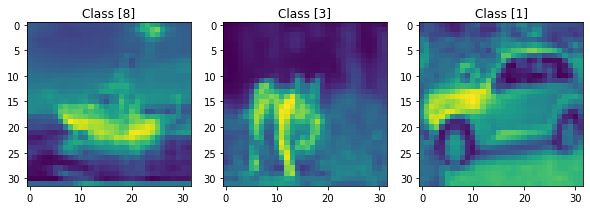

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(17, 8))
i=1
for element in ds_train.take(3): # take 5 images
  image, label = element[0], element[1]
  plt.subplot(1,5,i)
  plt.imshow(image.numpy()[:,:,0])
  plt.title("Class " + str(label.numpy()))
  i+=1

plt.show()

# these don't display very nicely, but this was the best I could do

In [7]:
# Cool. Those look good. Time to preprocess the data
import tensorflow as tf

def preprocess(image, label): 
  # image = tf.expand_dims(image, axis=2)
  # image = tf.image.grayscale_to_rgb(image)
  image = tf.image.resize(image, [224, 224])
  # image = tf.image.grayscale_to_rgb(image)
  return (image, label)



In [8]:
ds_train = ds_train.map(preprocess)

ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

In [9]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [10]:
ds_valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [11]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


# Model 1: EfficientNet WITHOUT Data Augmentation







In [95]:
# Try a simple model with no data augmentation
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg) 
output = keras.layers.Dense(10, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [96]:
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 [==============================] - 57s 37ms/step - loss: 0.3856 - accuracy: 0.8793 - val_loss: 0.2904 - val_accuracy: 0.8992
Epoch 2/50
1407/1407 [==============================] - 49s 35ms/step - loss: 0.2561 - accuracy: 0.9146 - val_loss: 0.2654 - val_accuracy: 0.9074
Epoch 3/50
1407/1407 [==============================] - 49s 35ms/step - loss: 0.2317 - accuracy: 0.9213 - val_loss: 0.2565 - val_accuracy: 0.9124
Epoch 4/50
1407/1407 [==============================] - 50s 35ms/step - loss: 0.2161 - accuracy: 0.9260 - val_loss: 0.2519 - val_accuracy: 0.9144
Epoch 5/50
1407/1407 [==============================] - 50s 36ms/step - loss: 0.2052 - accuracy: 0.9304 - val_loss: 0.2500 - val_accuracy: 0.9146
Epoch 6/50
1407/1407 [==============================] - 49s 35ms/step - loss: 0.1966 - accuracy: 0.9327 - val_loss: 0.2480 - val_accuracy: 0.9142
Epoch 7/50
1407/1407 [==============================] - 49s 35ms/step - loss: 0.1907 - accuracy: 0.9356 - val_loss: 0.2500 -

In [97]:
# Some retraining
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), 
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
1407/1407 [==============================] - 241s 134ms/step - loss: 0.2966 - accuracy: 0.9025 - val_loss: 0.1759 - val_accuracy: 0.9390
Epoch 2/100
1407/1407 [==============================] - 186s 133ms/step - loss: 0.0754 - accuracy: 0.9744 - val_loss: 0.1595 - val_accuracy: 0.9508
Epoch 3/100
1407/1407 [==============================] - 187s 133ms/step - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.1659 - val_accuracy: 0.9486
Epoch 4/100
1407/1407 [==============================] - 186s 132ms/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.1821 - val_accuracy: 0.9528
Epoch 5/100
1407/1407 [==============================] - 186s 132ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.1685 - val_accuracy: 0.9544
Epoch 6/100
1407/1407 [==============================] - 189s 134ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.1912 - val_accuracy: 0.9498
Epoch 7/100
1407/1407 [==============================] - 187s 133ms/step - loss: 0.0144 - accuracy: 0.9952

In [98]:
model.evaluate(ds_test)

# Okay this one was actually pretty good. More evaluations later.

313/313 [==============================] - 10s 31ms/step - loss: 0.1746 - accuracy: 0.9594


[0.17459611594676971, 0.9593999981880188]

In [16]:
import pickle

with open('model_1', 'wb') as file:
    pickle.dump(history.history, file)

In [17]:
keras.backend.clear_session()

# Model 2: EfficientNet with Data Augmentation



In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full,
                                                                y_train_full,
                                                                test_size=5000)

In [19]:
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [20]:
# We need another function for data augmentation
def preprocess(image, label): 
  # image = tf.image.grayscale_to_rgb(image) 
  image = tf.image.resize(image, [224, 224])
  return (image, label)


def data_aug(image, label): # the data augmentation function
  image = tf.image.random_flip_left_right(image)
  return (image, label) # might be able to add other image methods as well



In [21]:
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

In [22]:
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg) 
output = keras.layers.Dense(10, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [23]:
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 [==============================] - 58s 37ms/step - loss: 0.3917 - accuracy: 0.8775 - val_loss: 0.2942 - val_accuracy: 0.9040
Epoch 2/50
1407/1407 [==============================] - 51s 36ms/step - loss: 0.2561 - accuracy: 0.9134 - val_loss: 0.2745 - val_accuracy: 0.9088
Epoch 3/50
1407/1407 [==============================] - 51s 36ms/step - loss: 0.2309 - accuracy: 0.9210 - val_loss: 0.2700 - val_accuracy: 0.9096
Epoch 4/50
1407/1407 [==============================] - 51s 36ms/step - loss: 0.2161 - accuracy: 0.9264 - val_loss: 0.2655 - val_accuracy: 0.9118
Epoch 5/50
1407/1407 [==============================] - 51s 37ms/step - loss: 0.2048 - accuracy: 0.9307 - val_loss: 0.2660 - val_accuracy: 0.9120
Epoch 6/50
1407/1407 [==============================] - 51s 36ms/step - loss: 0.1961 - accuracy: 0.9339 - val_loss: 0.2669 - val_accuracy: 0.9110
Epoch 7/50
1407/1407 [==============================] - 50s 36ms/step - loss: 0.1903 - accuracy: 0.9356 - val_loss: 0.2665 -

In [24]:
# Some retraining
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), 
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
1407/1407 [==============================] - 241s 135ms/step - loss: 0.2998 - accuracy: 0.8994 - val_loss: 0.1429 - val_accuracy: 0.9490
Epoch 2/100
1407/1407 [==============================] - 189s 134ms/step - loss: 0.0746 - accuracy: 0.9758 - val_loss: 0.1459 - val_accuracy: 0.9554
Epoch 3/100
1407/1407 [==============================] - 193s 137ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.1463 - val_accuracy: 0.9548
Epoch 4/100
1407/1407 [==============================] - 188s 133ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.1588 - val_accuracy: 0.9592
Epoch 5/100
1407/1407 [==============================] - 188s 134ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.1669 - val_accuracy: 0.9574
Epoch 6/100
1407/1407 [==============================] - 188s 133ms/step - loss: 0.0173 - accuracy: 0.9940 - val_loss: 0.1592 - val_accuracy: 0.9552
CPU times: user 22min 12s, sys: 1min 31s, total: 23min 43s
Wall time: 20min 40s


In [25]:
model.evaluate(ds_test)

313/313 [==============================] - 10s 32ms/step - loss: 0.1656 - accuracy: 0.9581


[0.16558530926704407, 0.9581000208854675]

In [26]:
import pickle

with open('model_2', 'wb') as file:
    pickle.dump(history.history, file)

In [27]:
keras.backend.clear_session()

# Model 3: ResNet50 with Data Augmentation


In [28]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full,
                                                                y_train_full,
                                                                test_size=5000)

In [29]:
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [30]:
# We need another function for data augmentation
def preprocess(image, label): 
  # image = tf.image.grayscale_to_rgb(image) 
  image = tf.image.resize(image, [224, 224])
  return (image, label)


def data_aug(image, label): # the data augmentation function
  image = tf.image.random_flip_left_right(image)
  return (image, label) # might be able to add other image methods as well

In [31]:
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

# our data augmentation and preproces functions should already be in memory

In [32]:
ds_train # just to make sure they are the right size for debugging

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [33]:
ds_valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [34]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [39]:
# compile the model

# Implementing ResNet is almost identical to implementing EfficientNet

base_model = keras.applications.ResNet50(weights="imagenet",
                                         include_top=False,
                                         input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(10, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [40]:
# run the model
%%time
for layer in base_model.layers:
  layer.trainable = False


model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4),
                metrics=["accuracy"])

n_epochs = 50 #100 was just too long
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50
1407/1407 [==============================] - 88s 61ms/step - loss: 0.9931 - accuracy: 0.6674 - val_loss: 0.6382 - val_accuracy: 0.7924
Epoch 2/50
1407/1407 [==============================] - 85s 60ms/step - loss: 0.5961 - accuracy: 0.7986 - val_loss: 0.5318 - val_accuracy: 0.8262
Epoch 3/50
1407/1407 [==============================] - 84s 60ms/step - loss: 0.5202 - accuracy: 0.8236 - val_loss: 0.4863 - val_accuracy: 0.8432
Epoch 4/50
1407/1407 [==============================] - 84s 60ms/step - loss: 0.4825 - accuracy: 0.8363 - val_loss: 0.4600 - val_accuracy: 0.8490
Epoch 5/50
1407/1407 [==============================] - 85s 61ms/step - loss: 0.4532 - accuracy: 0.8440 - val_loss: 0.4403 - val_accuracy: 0.8564
Epoch 6/50
1407/1407 [==============================] - 85s 61ms/step - loss: 0.4333 - accuracy: 0.8521 - val_loss: 0.4266 - val_accuracy: 0.8620
Epoch 7/50
1407/1407 [==============================] - 85s 61ms/step - loss: 0.4169 - accuracy: 0.8594 - val_loss: 0.4168 -

In [41]:
# do some retraining. I think this one will benefit a lot from a little more training

%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4),
                metrics=["accuracy"])

n_epochs = 30
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/30
1407/1407 [==============================] - 340s 189ms/step - loss: 0.3439 - accuracy: 0.8879 - val_loss: 0.2499 - val_accuracy: 0.9142
Epoch 2/30
1407/1407 [==============================] - 266s 189ms/step - loss: 0.1372 - accuracy: 0.9535 - val_loss: 0.2328 - val_accuracy: 0.9270
Epoch 3/30
1407/1407 [==============================] - 265s 188ms/step - loss: 0.1002 - accuracy: 0.9649 - val_loss: 0.3693 - val_accuracy: 0.8832
Epoch 4/30
1407/1407 [==============================] - 265s 188ms/step - loss: 0.0843 - accuracy: 0.9708 - val_loss: 0.2076 - val_accuracy: 0.9358
Epoch 5/30
1407/1407 [==============================] - 265s 188ms/step - loss: 0.0683 - accuracy: 0.9764 - val_loss: 0.2798 - val_accuracy: 0.9152
Epoch 6/30
1407/1407 [==============================] - 265s 188ms/step - loss: 0.0578 - accuracy: 0.9801 - val_loss: 0.2419 - val_accuracy: 0.9310
Epoch 7/30
1407/1407 [==============================] - 265s 188ms/step - loss: 0.0525 - accuracy: 0.9825 - val_

In [42]:
model.evaluate(ds_test)

313/313 [==============================] - 17s 54ms/step - loss: 0.3764 - accuracy: 0.9075


[0.37636107206344604, 0.9075000286102295]

In [43]:
import pickle

with open('model_3', 'wb') as file:
    pickle.dump(history.history, file)

In [44]:
keras.backend.clear_session()

# Model 4: Xception with Data Augmentation

In [45]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full,
                                                                y_train_full,
                                                                test_size=5000)

In [46]:
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [47]:
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

# our data augmentation and preproces functions should already be in memory

In [48]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [49]:
ds_valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [50]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [51]:
base_model = keras.applications.Xception(weights="imagenet",
                                         include_top=False,
                                         input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(10, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [92]:
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 [==============================] - 120s 84ms/step - loss: 4.0565 - accuracy: 0.3659 - val_loss: 7.4104 - val_accuracy: 0.2448
Epoch 2/50
1407/1407 [==============================] - 126s 90ms/step - loss: 3.6186 - accuracy: 0.3866 - val_loss: 6.3857 - val_accuracy: 0.2788
Epoch 3/50
1407/1407 [==============================] - 117s 83ms/step - loss: 3.2908 - accuracy: 0.3965 - val_loss: 7.1372 - val_accuracy: 0.3038
Epoch 4/50
1407/1407 [==============================] - 117s 83ms/step - loss: 3.1033 - accuracy: 0.4009 - val_loss: 5.1415 - val_accuracy: 0.3060
Epoch 5/50
1407/1407 [==============================] - 117s 83ms/step - loss: 2.9078 - accuracy: 0.4064 - val_loss: 5.3027 - val_accuracy: 0.2992
Epoch 6/50
1407/1407 [==============================] - 116s 83ms/step - loss: 2.8306 - accuracy: 0.4052 - val_loss: 3.7500 - val_accuracy: 0.3470
Epoch 7/50
1407/1407 [==============================] - 116s 83ms/step - loss: 2.6834 - accuracy: 0.4086 - val_loss: 5

In [ ]:
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

In [55]:
model.evaluate(ds_test)

313/313 [==============================] - 24s 76ms/step - loss: 3.6627 - accuracy: 0.3785


[3.662656307220459, 0.3785000145435333]

In [56]:
import pickle

with open('model_4', 'wb') as file:
    pickle.dump(history.history, file)

In [57]:
keras.backend.clear_session()

# Analysis

In [61]:
history_1 = pickle.load(open('model_1', 'rb')) 

In [62]:
history_2 = pickle.load(open('model_2', 'rb')) 

In [65]:
history_3 = pickle.load(open('model_3', 'rb')) 

In [64]:
history_4 = pickle.load(open('model_4', 'rb')) 

In [68]:
history_1

{'accuracy': [0.8980888724327087,
  0.9861555695533752,
  0.9980888962745667,
  0.992377758026123,
  0.9935555458068848,
  0.9954666495323181,
  0.9951333403587341],
 'loss': [0.30811986327171326,
  0.04579373821616173,
  0.009186805225908756,
  0.022256353870034218,
  0.01966559700667858,
  0.013119067065417767,
  0.014335938729345798],
 'val_accuracy': [0.9524000287055969,
  0.9575999975204468,
  0.9557999968528748,
  0.9539999961853027,
  0.9585999846458435,
  0.9570000171661377,
  0.9606000185012817],
 'val_loss': [0.14067521691322327,
  0.13900010287761688,
  0.17227815091609955,
  0.17885975539684296,
  0.17143936455249786,
  0.1790332943201065,
  0.16975373029708862]}

In [74]:
history_2

{'accuracy': [0.899399995803833,
  0.9758444428443909,
  0.9894888997077942,
  0.9933111071586609,
  0.9945111274719238,
  0.9940000176429749],
 'loss': [0.2997707426548004,
  0.07464822381734848,
  0.033259354531764984,
  0.022015061229467392,
  0.01765119843184948,
  0.017331905663013458],
 'val_accuracy': [0.9490000009536743,
  0.9553999900817871,
  0.954800009727478,
  0.9592000246047974,
  0.9574000239372253,
  0.9552000164985657],
 'val_loss': [0.1428578943014145,
  0.1459316909313202,
  0.14629359543323517,
  0.1587623655796051,
  0.166935533285141,
  0.1591896414756775]}

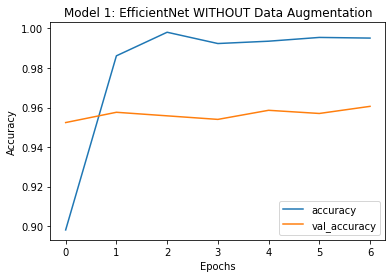

In [85]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(7), (history_1['accuracy']), label = 'accuracy')
plt.plot(np.arange(7), (history_1['val_accuracy']), label = 'val_accuracy')
# plt.plot(np.arange(7), (history_1['loss']), label = 'loss')
# plt.plot(np.arange(7), (history_1['val_loss']), label = 'val_loss')

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.title("Model 1: EfficientNet WITHOUT Data Augmentation")
plt.legend()

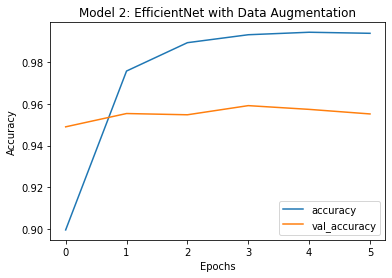

In [86]:
plt.plot(np.arange(6), (history_2['accuracy']), label = 'accuracy')
plt.plot(np.arange(6), (history_2['val_accuracy']), label = 'val_accuracy')
# plt.plot(np.arange(6), (history_2['loss']), label = 'loss')
# plt.plot(np.arange(6), (history_2['val_loss']), label = 'val_loss')

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.title("Model 2: EfficientNet with Data Augmentation")
plt.legend()

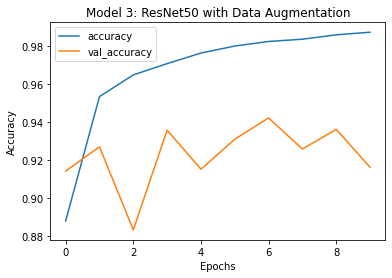

In [87]:
plt.plot(np.arange(10), (history_3['accuracy']), label = 'accuracy')
plt.plot(np.arange(10), (history_3['val_accuracy']), label = 'val_accuracy')

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.title("Model 3: ResNet50 with Data Augmentation")
plt.legend()

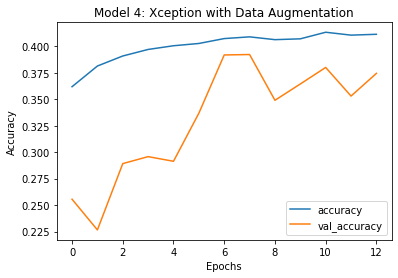

In [88]:
plt.plot(np.arange(13), (history_4['accuracy']), label = 'accuracy')
plt.plot(np.arange(13), (history_4['val_accuracy']), label = 'val_accuracy')

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.title("Model 4: Xception with Data Augmentation")
plt.legend()

## Model 1

The first model was an EfficientNet CNN with no data augmentation. It had a dropout layer of 0.5 and used the Nadam optimizer. It used softmax on its output later and trained with a patience of 5. 

This model had an accuracy of 0.957



## Model 2

My 2nd model used EfficentNet along with a data augmentation function. Other than the data augmentation function, it had the same parameters as model 1.

This model had an accuracy of 0.958




## Model 3

My 3rd model was an ResNet50 CNN with no data augmentation. It had a dropout layer of 0.5 and used the Nadam optimizer. It used softmax on its output later and trained with a patience of 5

This model had an accuracy of 0.907.



## Model 4
 
My 4th model was an Xception CNN with no data augmentation. It had a dropout layer of 0.5 and used the Nadam optimizer. It used softmax on its output later and trained with a patience of 5

This model had an accuracy of 0.388.

## Conclusion

The 4th model had a lot of problems and did not turn out very well, but the other three performed rather well. Though the first two models had very similiar accuracy, the 2nd model had the lowest loss and was less overfit than the first model, so it is probably my best model. 